In [1]:
import pandas as pd
import pandas_datareader as data
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
start_date = '1928-01-01'
end_date = '2022-08-01'
years = 40
tax = 0.2
init_amount = 0
max_amount = 20000000
step = 100000
monthly_min = 3000
monthly_max = 15000
monthly_step = 1000
min_amount_tolerable = 100000
inflation_on = True
dump_data = True
data_source = 'yahoo'
nasdaq = '^IXIC'
sap500 = '^GSPC'
dow = '^DJI'
tres10= '^TNX'
coke = 'KO'
ge = 'GE'
ibm = 'IBM'

result_df = pd.DataFrame(columns = ['start_date','principle','monthly','months_survive','survive'])

In [3]:
#validate code
#data.DataReader('nasdaq', data_source, start_date, end_date)[['Close']]

In [4]:
def prep_data(source=sap500):
    print('prep started')
    # pull raw data
    stock = data.DataReader(source, data_source, start_date, end_date)[['Close']]
    #pull the earliest stock date available
    new_start = stock.index[0]
    cpi = data.DataReader("CPIAUCNS", "fred", new_start, end_date)
    
    # user merger and then fill in monthly from the previous close if possible else the next close
    df = cpi.merge(stock, how='outer', left_index=True, right_index=True)
    df[['Close']] = df[['Close']].fillna(method='ffill').fillna(method='bfill')

    # remove non first month 
    df.dropna(inplace=True)

    # set placeholders
    df['inflation'] = 0.0
    df['change'] = 0.0
    df.reset_index(inplace=True)

    # calculate baseline df
    for i in range(len(df)):
        # skip the first iteration
        if i == 0: continue
        # update inflation
        if inflation_on:
            p_cpi = df.at[i-1,'CPIAUCNS']
            c_cpi = df.at[i,'CPIAUCNS']
            df.at[i,'inflation']= (c_cpi - p_cpi)/p_cpi
        # update percent change
        p_close = df.at[i-1,'Close']
        c_close = df.at[i,'Close']
        df.at[i,'change'] = (c_close - p_close)/p_close
    print('prep done')
    return df

In [5]:
def model_year(prin, start_date_index, withdrawal, df):
    global result_df
    # calculates the model year and inserts into results df
    # returns boolean for making it to the end of the year
    failed = False
    s_date = df.at[start_date_index,'index'].strftime('%Y_%m_%d')
    mnth = f'monthly_{s_date}_{prin}_{withdrawal}'
    prcp = f'principle_{s_date}_{prin}_{withdrawal}'
    df[mnth] = np.nan
    df[prcp] = np.nan
    k=0
    end = start_date_index + years*12 +1
    start = df.at[start_date_index,'index']
    for i in range(start_date_index,end):
        if k==0:
            df.at[i,mnth]= withdrawal
            df.at[i,prcp]= prin
            k+=1
            continue
        if i > len(df):
            break
        p = i-1
        # previous monthly * (1+inflation)
        p_m = df.at[p,mnth]
        c_i = df.at[i,'inflation']
        c_m = p_m*(1+c_i)
        df.at[i,mnth]= c_m
        # (previous principle*(1+change)) - current monthly
        p_p = df.at[p,prcp]
        p_c = df.at[p,'Close']
        c_c = df.at[i,'Close']
        change =  (c_c-p_c)/p_c
        c_p = p_p*(1+change)-c_m
        df.at[i,prcp]= c_p
        failed = (c_p <= min_amount_tolerable)
        if failed or i == end-1:
            res = pd.DataFrame.from_dict({'start_date': [start], 'principle': prin, 'monthly': withdrawal,'months_survive': [i-start_date_index], 'survive': [not failed]})
            result_df = pd.concat([result_df,res], ignore_index=True)
            break
    if dump_data:
        df.drop(columns=[mnth,prcp], inplace=True)
    return failed
    

In [6]:
# Testing
# model_year(init_amount, 0, 8000, df)
# result_df.head()

In [7]:
def seek_year(sdi, p_min, p_max, step, withdrawal, baseline_df):
    # sdi = start date index 
    # p_min = principle min
    # p_max = principle max
    # step = increase step from in to max
    
    # presumes failed state
    failed = True
    for prin in range(p_min,p_max,step):
        failed = model_year(prin, sdi, withdrawal, baseline_df)
        # exists when succeeds
        if not failed:
            break

In [8]:
# Testing
# seek_year(0, init_amount, max_amount, step, monthly,df)
# result_df.head()

In [9]:
%%time
model = nasdaq
model_df = prep_data(model)
lsi = int((len(model_df)- years*12)/12)
for s in range(lsi + 1):
    s_date_i = s*12
    year = model_df.at[s_date_i,'index'].strftime('%Y_%m_%d')
    print(f'analyzing year: {year} {s+1} of {lsi + 1}')
    for monthly in range(monthly_min,monthly_max+monthly_step,monthly_step):
        seek_year(s_date_i, init_amount, max_amount, step, monthly, model_df)

prep started
prep done
analyzing year: 1971_03_01 1 of 12
analyzing year: 1972_03_01 2 of 12
analyzing year: 1973_03_01 3 of 12
analyzing year: 1974_03_01 4 of 12
analyzing year: 1975_03_01 5 of 12
analyzing year: 1976_03_01 6 of 12
analyzing year: 1977_03_01 7 of 12
analyzing year: 1978_03_01 8 of 12
analyzing year: 1979_03_01 9 of 12
analyzing year: 1980_03_01 10 of 12
analyzing year: 1981_03_01 11 of 12
analyzing year: 1982_03_01 12 of 12
CPU times: user 10.2 s, sys: 71.2 ms, total: 10.3 s
Wall time: 11.9 s


In [10]:
survive_df = result_df[result_df.survive]

principle    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

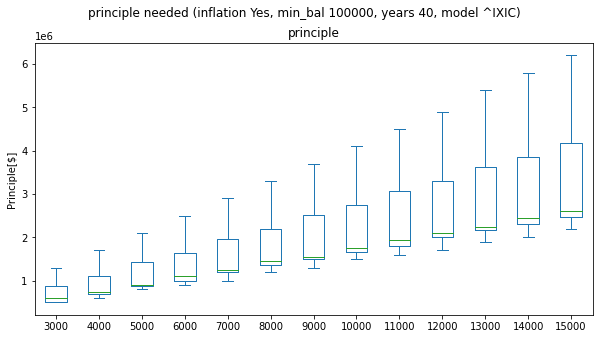

In [11]:
inf_text = 'Yes' if inflation_on else 'No'
title = f'principle needed (inflation {inf_text}, min_bal {min_amount_tolerable}, years {years}, model {model})'
x_l = 'monthly withdrawal'
y_l = 'Principle[$]'

survive_df.plot.box(column=["principle"], by=['monthly'], title=title, ylabel=y_l, xlabel=x_l, figsize=(10,5))

In [12]:
survive_df[['principle','monthly']].astype('int').groupby('monthly').describe()

principle                                                    \
            count          mean           std        min        25%   
monthly                                                               
3000         12.0  7.166667e+05  2.886751e+05   500000.0   500000.0   
4000         12.0  9.416667e+05  3.752777e+05   600000.0   700000.0   
5000         12.0  1.166667e+06  4.849242e+05   800000.0   875000.0   
6000         12.0  1.375000e+06  5.642775e+05   900000.0  1000000.0   
7000         12.0  1.608333e+06  6.721179e+05  1000000.0  1200000.0   
8000         12.0  1.833333e+06  7.389591e+05  1200000.0  1375000.0   
9000         12.0  2.041667e+06  8.628266e+05  1300000.0  1500000.0   
10000        12.0  2.266667e+06  9.470848e+05  1500000.0  1675000.0   
11000        12.0  2.491667e+06  1.042251e+06  1600000.0  1800000.0   
12000        12.0  2.708333e+06  1.134948e+06  1700000.0  2000000.0   
13000        12.0  2.950000e+06  1.238401e+06  1900000.0  2175000.0   
14000        12.0  3.158333e+06  1.336521e+06  2000000.0  2300000.0   
15000        12.0  3.391667e+06  1.441879e+06  2200000.0  2475000.0   

                                          
               50%        75%        max  
monthly                                   
3000      600000.0   875000.0  1300000.0  
4000      750000.0  1100000.0  1700000.0  
5000      900000.0  1425000.0  2100000.0  
6000     1100000.0  1650000.0  2500000.0  
7000     1250000.0  1975000.0  2900000.0  
8000     1450000.0  2200000.0  3300000.0  
9000     1550000.0  2525000.0  3700000.0  
10000    1750000.0  2750000.0  4100000.0  
11000    1950000.0  3075000.0  4500000.0  
12000    2100000.0  3300000.0  4900000.0  
13000    2250000.0  3625000.0  5400000.0  
14000    2450000.0  3850000.0  5800000.0  
15000    2600000.0  4175000.0  6200000.0